# Определение стоимости автомобилей

## Введение

### Постановка задачи

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)


## Загрузка библиотек

In [1]:
# библиотеки
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import datetime as dt
import matplotlib as plt

# предварительные настройки библиотек
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 15})

# методы для создания и обучения моделей 
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.m_estimate import MEstimateEncoder

In [2]:
# константы
RANDOM_STATE = 12345

## Подготовка данных

### Загрузка данных

In [3]:
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [4]:
# загружаем данные из файла
data = pd.read_csv('datasets/autos.csv')

In [5]:
# выведем общую информацию
first_look(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: 

None

Первые 5 строк(и) данных


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Основные статистические характеристики данных


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество пропусков:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество дубликатов: 4


In [6]:
data[data.duplicated()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15



Дубликаты не несут полезной для обучения модели информации, поэтому удалим их.


In [7]:
data = data.drop_duplicates()

In [8]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


In [9]:
first_data_shape = data.shape[0]
first_data_shape

354365

### Аномалии в столбцах

Первое знакомство с данными выявило наличие аномалий в следующих столбцах:
- год регистрации автомобиля
- месяц регистрации автомобиля
- мощность двигателя
- количество фотографий автомобиля
- цена

**Год регистрации авто.**

In [10]:
sorted(data['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

В наших данных содержатся объявления о продаже авто с 2014 по 2016 год. Тем не менее, среди значений года регистрации есть числа больше 2016. Посмотрим на их количество.

In [11]:
# количество авто, зарегистрированных после 2016 года
data[data['RegistrationYear'] > 2016].shape[0]

14530

In [12]:
# процент авто, зарегистрированных после 2016 года
data[data['RegistrationYear'] > 2016].shape[0] / first_data_shape * 100

4.100292071733946

Возможно, это данные о предварительных заказах. Посмотрим на значение пробега для этих автомобилей.

In [13]:
sorted(data[data['RegistrationYear'] > 2016]['Kilometer'].unique())

[5000,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 125000,
 150000]

Видим, что минимальное значение пробега – 5 000 км. То есть автомобиль еще не сошел с конвейера, а уже проехал более 5 000 км. Это говорит о том, что данные содержат ошибку. 

In [14]:
data[(data['RegistrationYear'] < 1910) | (data['RegistrationYear'] > 2016)].shape[0]

14596

In [15]:
data[(data['RegistrationYear'] < 1910) | (data['RegistrationYear'] > 2016)].shape[0] / data.shape[0] * 100

4.118916935927645

Их общее количество не превышает 5%.

Так как количество автомобилей с ошибочными данными о годе регистрации мало, а подобрать способ достоверно восстановить реальный год регистрации не представляется возможным, удалим эти наблюдения. 

В дальнейшем при развертывании модели следует предусмотреть контроль правильности заполнения данных пользователем.


In [16]:
data = data[(1910 <= data['RegistrationYear']) & (data['RegistrationYear'] <= 2016) ]

**Месяц регистрации авто**

In [17]:
sorted(data['RegistrationMonth'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Видим, что в столбце в качестве месяца  регистрации встречается 13 значений.

Месяц регистрации вряд ли оказывает большое влияние на цену автомобиля (позже посмотрим его коэффициент корреляции с целевым признаком), гораздо важнее для нас год регистрации. Поэтому исправлять аномалии здесь не будем, просто не будем использовать столбец с месяцем регистрации в качестве характеристики для обучения модели.

**Количество фотографий автомобиля**

In [18]:
data['NumberOfPictures'].value_counts()

NumberOfPictures
0    339769
Name: count, dtype: int64

Весь столбец с количеством фотографий состоит из нулей, значит, неинформативен для моделей. Не будем использовать его в качестве характеристики для обучения модели.

**Мощность двигателя**

In [19]:
sorted(data['Power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


При беглом изучении интернет-публикаций о мощности двигателя выяснилось следующее: в 2010 году американская компания TranStar выпустила свой первый «Кинжал» Dagger GT, у которого под капотом размещен двигатель V8 на 9.4 литра, способный выдавать 2028 лошадей и достигать скорости 483 км/ч.
С другой сотороны, мощность двигателя не может быть равна 0.
Таким образом, установим допустимый диапазон мощности двигателя от 1 до 2000 лошадиных сил. 

In [20]:
data[(data['Power'] == 0) | (data['Power'] > 2000)].shape[0]

36562

In [21]:
data[(data['Power'] == 0) | (data['Power'] > 2000)].shape[0] / data.shape[0] * 100

10.760840453366846

Лучше не удалять более 10 % данных, поэтому исправим аномальные значения. Те, которые, попадают за пределы диапазона от 1 до 2000 заменим в трансформере на граничные значения - 1 и 2000.

**Цена автомобиля**

In [22]:
# диапазон значений
data['Price'].min(), data['Price'].max()

(0, 20000)

In [23]:
# процент наблюдений с нулевой ценой
data[data['Price'] == 0].shape[0] / data.shape[0] * 100

2.945530639934779

Нулевая цена авто является аномальным значением при продаже, достоверного способа заменить эти значения нет, поэтому удалим эти строки.

In [24]:
data = data[data['Price'] > 0]

**Kilometer**

In [25]:
data['Kilometer'].min(), data['Kilometer'].max()

(5000, 150000)

Данные о пробеге содержат адекватные значения.

**PostalCode**

In [26]:
# диапазон значений почтового индекса
data['PostalCode'].min(), data['PostalCode'].max()

(1067, 99998)

In [27]:
data['PostalCode'].unique()

array([70435, 66954, 90480, ..., 14053, 38325, 89344], dtype=int64)

Почтовый индекс может содержать от 4 (например, Австралия) до 9 (США) цифр и букв в зависимости от страны. Значения столбца PostalCode удовлетворяют этим условиям. Оставляем их без изменений.

Посмотрим на значения некоторых почтовых индексов:

70435 Штутгарт, Германия

1067 Амстердам,  Голландия

38325 Чхондо, Южная Корея

Видно, что в нашей базе данных собраны объявления из нескольких стран. Регион продажи может оказывать влияние на цену, по которой автомобиль будет продан на вторичном рынке, так что оставим его в списке характеристик.


**Контроль процента удаленных данных**

In [28]:
# удаление пробелов в индексах
data.reset_index(drop=True, inplace=True)

In [29]:
# новое количество строк
data.shape[0]

329761

In [30]:
# количество удаленных строк
first_data_shape - data.shape[0]

24604

In [31]:
# процент удаленных данных
(first_data_shape - data.shape[0]) / first_data_shape * 100

6.943123615481213

После выявления аномальных значений были удалены те, которые было невозможно исправить, а это менее 7 %. Процент удаления допустимый.

### Анализ пропусков

Наши данные содержат пропуски в 5 характеристиках: в данных о модели, о ремонте авто, типах кузова, коробки передач и топлива. 

Напишем трансформер, который будет заполнять пропуски автоматически. 

Для начала проведем анализ значений характеристик с пропусками.

**Модель автомобиля**

Заполнение пропусков начнем с модели авто, потому что, зная модель машины можно будет восстановить пропущенные значения других столбцов.

Посмотрим сколько всего моделей встречается в данных и нет ли среди них неявных дубликатов.

In [32]:
data['Model'].nunique()

250

In [33]:
sorted(data['Model'].dropna().unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Видим, что пропуски в данных о модели имеют вид не только nan, но и частично заполнены значением other. Возможно, у пользователя не было возможности вписать модель авто самостоятельно, а приходилось выбирать из выпадающего списка. Для моделей, отсутствующих в списке, была доступна опция other. 

Кроме пропусков видим неявные дубликаты: модель range_rover допускает различные варианты написания. Оставим только один из них. Пропуски заполним значением other.


**Тип кузова**

In [34]:
# посмотрим на список значений типа кузова 
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Информация о типе кузова содержит пропуски в виде nan и значения other. Попробуем их заполнить в зависимости от типа модели автомобиля. Сгруппируем данные по моделям авто и заполним пропуски модой типа кузова для каждой модели. Оставшиеся пропуски заполним значением other.

**Тип коробки передач**

In [35]:
# посмотрим на список значений типа коробки передач 
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Видим, что базе данных только два вида коробки передач, пропуски имеют вид только nan, значение other здесь не используется. Заполним пропуски типа коробки передач также, как заполняли тип кузова: модой для каждой модели. Остальные пропуски заполним значением unknown

**Тип топлива**

In [36]:
# посмотрим на список значений типа топлива 
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Пропуски типа топлива имеют вид nan и other. Заменим nan модой для каждой модели там, где это возможно. Остальные пропуски заполним значением other.

**Данные о ремонте**

In [37]:
# посмотрим на список значений данных о ремонте 
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [38]:
# количество авто, для которых данные о ремонте отсутствуют
data['Repaired'].isna().sum() / data.shape[0] * 100

18.159212277983144

20 % данных о ремонте отсутствуют. Возможно, эти машины не были в ремонте, и их владельцы не стали заполнять это поле, но точно утверждать мы не можем, поэтому заполним их значением unknown. Это позволит модели выявить зависимость между отсутствием данных о ремонте и ценой на авто, если такая зависимость есть.

**Трансформер для обработки данных**

Все выработанные для обработки данных правила обработки пропусков и аномалий соберем в трансформере DataCleaner:
- модель авто: 
    - замена разных вариантов написания range_rover
    - заполнение пропусков значением other

- тип кузова
    - для имеющихся в базе моделей пропуски заполним модальным значением
    - для остальных - значением other

- коробка передач
    - для имеющихся в базе моделей пропуски заполним модальным значением
    - для остальных – значением unknown

- тип топлива
    - для имеющихся в базе моделей пропуски заполним модальным значением
    - для остальных - значением other

- мощность двигателя
    - значения, равные 0 заполним значением 1
    - значения больше 2000 значением 2000


In [39]:
class DataCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.models_to_replace = {
            'range_rover_evoque' : 'range_rover',
            'range_rover_sport' : 'range_rover',
            'rangerover' : 'range_rover'
        }
        self.min_power = 1
        self.max_power = 2000
    
    def fit(self, X):
        # оставляем для расчётов только значения без пропусков модели авто
        na_s = [np.nan, 'other']
        X_tmp = X.query('Model not in @na_s')
        
        # словарь моделей и мод типа кузова
        self.model_and_VehicleType = {}
        for model in X_tmp['Model'].unique():
            if not X_tmp[(X_tmp['Model'] == model)]['VehicleType'].mode().empty:
                self.model_and_VehicleType[model] = \
                X_tmp[(X_tmp['Model'] == model)]['VehicleType'].mode().values[0]
        
        # словарь моделей и мод типа коробки передач
        self.model_and_Gearbox = {}
        for model in X_tmp['Model'].unique():
            if not X_tmp[(X_tmp['Model'] == model)]['Gearbox'].mode().empty:
                self.model_and_Gearbox[model] = \
                X_tmp[(X_tmp['Model'] == model)]['Gearbox'].mode().values[0]

        # словарь моделей и мод типа топлива
        self.model_and_FuelType = {}
        for model in X_tmp['Model'].unique():
            if not X_tmp[(X_tmp['Model'] == model)]['FuelType'].mode().empty:
                self.model_and_FuelType[model] = \
                X_tmp[(X_tmp['Model'] == model)]['FuelType'].mode().values[0]
        return self

    def transform(self, X):
         
        # обработка дубликатов и пропусков модели авто
        X['Model'].replace(self.models_to_replace, inplace=True)
        X['Model'].fillna('other', inplace=True)
        
        # заполняем пропуски типа кузова
        for model in self.model_and_VehicleType.keys():
            X.loc[(X['Model'] == model) & (X['VehicleType'].isna()), 'VehicleType'] =\
            self.model_and_VehicleType[model]
        X['VehicleType'].fillna('other', inplace=True)  
        
        # заполняем пропуски коробки передач
        for model in self.model_and_Gearbox.keys():
            X.loc[(X['Model'] == model) & (X['Gearbox'].isna()), 'Gearbox'] =\
            self.model_and_Gearbox[model]
        X['Gearbox'].fillna('unknown', inplace=True)  
        
        # заполняем пропуски типа топлива
        for model in self.model_and_Gearbox.keys():
            X.loc[(X['Model'] == model) & (X['FuelType'].isna()), 'FuelType'] =\
            self.model_and_Gearbox[model]
        X['FuelType'].fillna('other', inplace=True)            
        
        # заполняем пропуски о ремонте
        X['Repaired'].fillna('unknown', inplace=True)   
        
        # корректируем данные о мощности двигателя
        X.loc[X['Power'] < self.min_power, 'Power'] = self.min_power
        X.loc[X['Power'] > self.max_power, 'Power'] = self.max_power
        
        return X

### Доработка набора признаков

В дате создания анкеты нам важен год, он может помочь модели точнее рассчитать цену автомобиля. 

Также на основании этой даты мы можем вычислить возраст авто.


In [40]:
# приведем дату регистрации анкеты к типу datetime 
data['DateCreated'] = pd.to_datetime(
    data['DateCreated'],
    format='%Y-%m-%d %H:%M:%S'
)

In [41]:
# оставим только год
data['YearCreated'] = pd.DatetimeIndex(data['DateCreated']).year

In [42]:
sorted(data['YearCreated'].unique())

[2014, 2015, 2016]

Вычислим возраст авто

In [43]:
data['Age'] = data['YearCreated'] - data['RegistrationYear']

In [44]:
data['Age'].min(), data['Age'].max()

(0, 106)

In [45]:
data[data['Age'] == 0].shape[0] / data.shape[0] * 100

2.7198486176351966

Настораживает наличие автомобилей, возраст которых равен 0. Но такое возможно, если человек приобрел машину, пользовался ею в течение нескольких месяцев и в том же году решил продать. Оставляем эти строки.

Создадим столбец с характеристикой интенсивности использования авто, которую на основе имеющихся данных рассчитаем как отношение величины пробега к возрасту авто, то есть, сколько километров в год  в среднем проезжал автомобиль.

In [46]:
def km_per_year_count(row):
    if row['Age'] > 0:
        return row['Kilometer'] / row['Age']
    else:
        return row['Kilometer']

In [47]:
data['Km_per_year'] = data.apply(km_per_year_count, axis=1)

In [48]:
# проверим, все ли строки заполнены
data['Km_per_year'].isna().sum()

0

На этом генерацию дополнительных признаков закончим. Теперь посмотрим, какие характеристики являются неинформативными для моделей.

In [49]:
num_features = [ 
    'RegistrationYear',
    'Power',
    'Kilometer',
    'RegistrationMonth',  
    'PostalCode',  
    'Age',
    'Km_per_year',
    'Price'
]

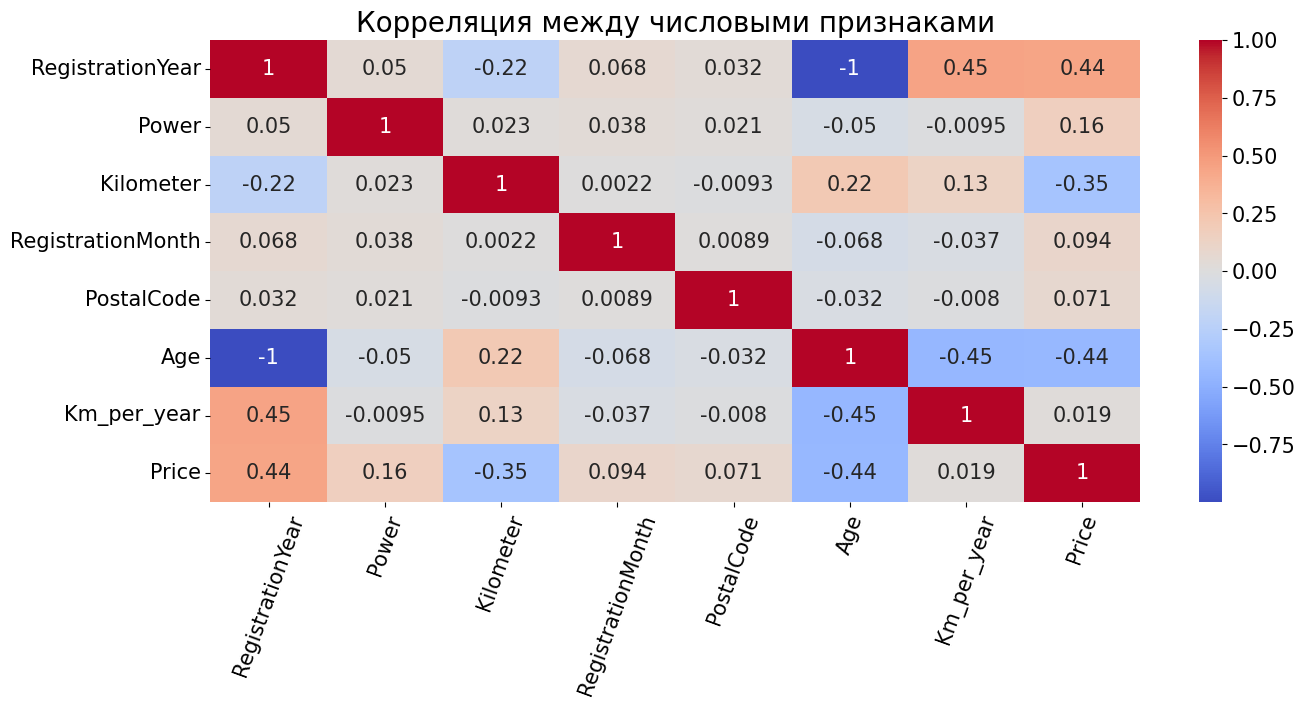

In [50]:
# посмотрим на корреляцию числовых признаков между собой
chart = sns.heatmap(
    data[num_features].corr(),
    cmap='coolwarm',
    annot=True
)
chart.set_title('Корреляция между числовыми признаками', fontsize=20)
chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
fig = chart.get_figure()
fig.set_size_inches(15, 6)
chart;

Среди признаков уберем малоинформативные для нас: 
- NumberOfPictures, так как весь столбец состоит из 0
- DateCrawled, LastSeen и RegistrationMonth, так как они мало влияют на цену
- DateCreated и YearCreated, так как на их основе вычислен признак Age с высокой корреляцией с целевым признаком 

### Подготовка выборок для обучения моделей

В отдельные переменные посетим характеристики и целевой признак.

In [51]:
features = data.drop(
    ['Price', 
     'NumberOfPictures', 
     'DateCrawled', 
     'DateCreated', 
     'YearCreated',
     'RegistrationMonth',
     'LastSeen'    ], 
    axis=1)
target = data['Price']

Разобьем данные на тренировочную и тестовую выборки в соотношении 4 : 1.

In [52]:
# список категориальных переменных для дальнейшего использования
features_train, features_test, \
target_train, target_test = train_test_split(
    features,
    target,
    test_size=.2,
    random_state=RANDOM_STATE
)

In [53]:
# проверка размерности
features_train.shape[0] + features_test.shape[0] == data.shape[0]

True

In [54]:
# проверка размерности
target_train.shape[0] + target_test.shape[0] == data.shape[0]

True

После того, как выборки подготовлены, применим к ним наш трансформер для заполнения признаков и обработки аномалий.

In [55]:
dc = DataCleaner()

In [56]:
# контроль пропусков
features_train.isna().sum()

VehicleType         15970
RegistrationYear        0
Gearbox             12530
Power                   0
Model               12557
Kilometer               0
FuelType            19344
Brand                   0
Repaired            47941
PostalCode              0
Age                     0
Km_per_year             0
dtype: int64

In [57]:
# контроль пропусков
features_test.isna().sum()

VehicleType          3967
RegistrationYear        0
Gearbox              3072
Power                   0
Model                3080
Kilometer               0
FuelType             4831
Brand                   0
Repaired            11941
PostalCode              0
Age                     0
Km_per_year             0
dtype: int64

In [58]:
# преобразование обучающей выборки
features_train = dc.fit_transform(features_train)

In [59]:
# контроль пропусков
features_train.isna().sum()

VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
PostalCode          0
Age                 0
Km_per_year         0
dtype: int64

In [60]:
# преобразование тестовой выборки
features_test = dc.transform(features_test)

In [61]:
# контроль пропусков
features_test.isna().sum()

VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
PostalCode          0
Age                 0
Km_per_year         0
dtype: int64

Видим, что все пропуски в данных заполнены.

### Вывод по предварительному анализу данных

Нам доступны данные, которые содержат **354 369 строк, 15 характеристик и целевой признак**.

В данных содержатся дубликаты, пропуски и аномальные значения.

В результате предварительной обработки **удалены аномальные значения** в столбцах с данными о годе регистрации и цене авто. Для обработки аномальных значений в данных о мощности двигателя некорректные данные заменяются граничными значениями 1 и 2000 л.с. Всего удалено менее 7 % наблюдений.

**Обработаны пропуски** в данных о модели авто, о типе кузова, коробки передач и топлива, о факте проведения ремонта. Пропуски в данных о модели заполнены значением other (которое уже присутствует в данных), в данных о ремонте – значением unknown. Пропуски остальных характеристик заполняются, где возможно, модальным значением для каждой модели, в остальных случаях используются значения other или unknown. 

Для предварительной обработки данных **написан трансформер**, который можно будет **передать заказчику вместе с моделью**.

На основе имеющихся данных **добавлены новые характеристики**:
- возраст автомобиля
- средний пробег авто за год

**Проведен отбор признаков**, выявлены неинформативные для модели.

Данные разбиты на обучающую и тестовую выборки.


## Обучение моделей

Обучим на наших данных три модели: LGBMRegressor, CatBoostRegressor и LinearRegression. Для каждой подберем гиперпараметры и измерим время обучения и предсказания.

Для двух первых моделей необходимо указать категориальные признаки.

In [62]:
cat_features = [
    'VehicleType', 
    'Gearbox', 
    'Model',
    'FuelType', 
    'Brand', 
    'Repaired'
     ]

In [63]:
features_train[cat_features] = features_train[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')

### LGBMRegressor

In [64]:
# список гиперпараметров и их значений
search_space = {
    'n_jobs' : [6, 8],
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [200, 500, 1000],
    'max_depth' : [5, 10],
    'num_leaves' : [10, 20, 30]
}

In [65]:
model_LGBMR = LGBMRegressor(
    random_state=RANDOM_STATE,
    force_row_wise=True
)

In [66]:
GS_for_LGBMR = GridSearchCV(
    estimator=model_LGBMR,
    param_grid=search_space,
    scoring='neg_mean_squared_error',
    refit='neg_mean_squared_error',
    cv=3,
    verbose=0
)

In [67]:
# подбор гиперпараметров
start_time = dt.datetime.now().timestamp()
GS_for_LGBMR.fit(features_train, target_train)
time_spent_LGBMR_gs = dt.datetime.now().timestamp() - start_time

[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 175872, number of used features: 12
[LightGBM] [Info] Start training from score 4612.117045
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 175872, number of used features: 12
[LightGBM] [Info] Start training from score 4603.237235
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 175872, number of used features: 12
[LightGBM] [Info] Start training from score 4615.710028
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 175872, number of used features: 12
[LightGBM] [Info] Start training from score 4612.117045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [68]:
time_spent_LGBMR_gs / 60, time_spent_LGBMR_gs % 60

(4.98553083340327, 59.13185000419617)

In [69]:
# лучший результат RMSE
print('LGBMRegressor RMSE:', abs(GS_for_LGBMR.best_score_) ** 0.5)

LGBMRegressor RMSE: 1579.9210812373576


In [70]:
print('Время обучения модели:', GS_for_LGBMR.cv_results_['mean_fit_time'][GS_for_LGBMR.best_index_])

Время обучения модели: 1.634502649307251


In [71]:
print('Время предсказания модели:', GS_for_LGBMR.cv_results_['mean_score_time'][GS_for_LGBMR.best_index_])

Время предсказания модели: 0.5273054440816244


### CatBoostRegressor

In [72]:
# список гиперпараметров и их значений
search_space = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [100, 200, 500],
    'max_depth' : [5, 10], 
    'reg_lambda' : [0.5, 0.1, 0.01]
}

In [73]:
model_CBR = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    verbose=0
)

In [74]:
GS_for_CBR = GridSearchCV(
    estimator=model_CBR,
    param_grid=search_space,
    scoring='neg_mean_squared_error',
    refit='neg_mean_squared_error',
    cv=3,
    verbose=4 
)

In [75]:
# подбор гиперпараметров
start_time = dt.datetime.now().timestamp()
GS_for_CBR.fit(features_train, target_train)
time_spent_cbr_gs = dt.datetime.now().timestamp() - start_time

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.5;, score=-3458029.304 total time=   3.2s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.5;, score=-3515457.517 total time=   2.9s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.5;, score=-3462795.109 total time=   3.0s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.1;, score=-3458074.321 total time=   2.9s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.1;, score=-3529515.192 total time=   3.0s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.1;, score=-3489035.990 total time=   2.9s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.01;, score=-3461568.953 total time=   2.9s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.01;, score=-3513538.023 total time=

In [76]:
time_spent_cbr_gs // 60

43.0

In [77]:
# лучший результат RMSE
print('CatBoostRegressor RMSE:', abs(GS_for_CBR.best_score_) ** 0.5)

CatBoostRegressor RMSE: 1601.7889362308906


In [78]:
print('Время обучения модели:', GS_for_CBR.cv_results_['mean_fit_time'][GS_for_CBR.best_index_])

Время обучения модели: 67.17594663302104


In [79]:
print('Время предсказания модели:', GS_for_CBR.cv_results_['mean_score_time'][GS_for_CBR.best_index_])

Время предсказания модели: 0.10051004091898601


### LinearRegression

Для запуска линейной регрессии требуется предварительная обработка данных.

Среди категориальных переменных есть Brand и Model. В них содержится большое количество уникальных значений: 

In [80]:
features_train['Brand'].nunique() + features_train['Model'].nunique()

287

Если передать их в OneHotEncoder, то это приведет к добавлению 285 новых столбцов. Чтобы этого избежать, для Brand и Model будем использовать MEstimateEncoder из библиотеки category_encoders, в основе которого лежит метод максимального правдоподобия. 

Остальные категориальные переменные преобразуем с помощью OneHotEncoder.


In [81]:
mee = MEstimateEncoder(
    cols=['Brand', 'Model'], 
    random_state=RANDOM_STATE
)

In [82]:
# преобразование обучающей выборки
features_train = mee.fit_transform(features_train, target_train)

In [83]:
# преобразование тестовой выборки
features_test = mee.transform(features_test)

In [84]:
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,Age,Km_per_year
197449,sedan,1999,manual,139,1064.052328,150000,petrol,1037.469407,yes,37154,17,8823.529412
21337,sedan,2010,auto,204,6562.391349,150000,gasoline,6402.411356,no,58285,6,25000.000000
213579,convertible,2009,auto,71,3690.483909,50000,petrol,3590.601873,no,61440,7,7142.857143
241155,convertible,2001,manual,101,3148.848808,150000,petrol,2852.855976,no,81829,15,10000.000000
100755,sedan,2008,manual,143,6001.289622,150000,gasoline,6530.360309,no,21075,8,18750.000000


In [85]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first'
)

In [86]:
# обновим список категориальных переменных
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

In [87]:
features_train_cat = features_train[cat_features]

In [88]:
enc.fit(features_train_cat)

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [89]:
features_train_cat = pd.DataFrame(enc.transform(features_train_cat))
features_train_cat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263803,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
263804,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
263805,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
263806,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [90]:
features_test_cat = features_test[cat_features]
features_test_cat = pd.DataFrame(enc.transform(features_test_cat))
features_test_cat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65948,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65949,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65950,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65951,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [91]:
num_features = [ 
    'RegistrationYear',
    'Power',
    'Kilometer',
    'PostalCode',  
    'Age',
    'Km_per_year'
]

In [92]:
features_train_ohe =pd.merge(
    features_train_cat.add_prefix('ohe'), 
    features_train[num_features].reset_index(drop=True), 
    left_index=True, 
    right_index=True)
features_train_ohe

,ohe0,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7,ohe8,ohe9,...,ohe15,ohe16,ohe17,ohe18,RegistrationYear,Power,Kilometer,PostalCode,Age,Km_per_year
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2012,99,10000,31787,4,2500.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2011,105,30000,53902,5,6000.000000
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2004,75,150000,35708,12,12500.000000
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2006,224,150000,83022,10,15000.000000
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2003,54,150000,21502,13,11538.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263803,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1995,150,150000,14469,21,7142.857143
263804,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1991,54,150000,21775,25,6000.000000
263805,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2011,111,90000,54574,5,18000.000000
263806,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2000,101,125000,32257,16,7812.500000


In [93]:
features_test_ohe = pd.merge(
    features_test_cat.add_prefix('ohe'), 
    features_test[num_features].reset_index(drop=True), 
    left_index=True, 
    right_index=True)
features_test_ohe

,ohe0,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7,ohe8,ohe9,...,ohe15,ohe16,ohe17,ohe18,RegistrationYear,Power,Kilometer,PostalCode,Age,Km_per_year
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1999,139,150000,37154,17,8823.529412
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2010,204,150000,58285,6,25000.000000
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2009,71,50000,61440,7,7142.857143
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2001,101,150000,81829,15,10000.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2008,143,150000,21075,8,18750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65948,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1997,170,150000,72766,19,7894.736842
65949,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1997,60,150000,33442,19,7894.736842
65950,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2007,54,80000,89558,9,8888.888889
65951,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1993,86,70000,1259,23,3043.478261


Теперь данные нужно масштабировать.

In [94]:
# будем использовать StandardScaler
sscaler = StandardScaler()

In [95]:
features_train_ohe_scaled = pd.DataFrame(sscaler.fit_transform(features_train_ohe))
features_train_ohe_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.254462,-0.225058,-0.156947,-0.641524,1.730599,-0.194614,-0.497128,0.512264,-0.109116,-0.040264,...,-0.143145,0.781534,-0.471260,-0.332738,1.354703,-0.141834,-3.146984,-0.736954,-1.354686,-0.545967
1,-0.254462,-0.225058,-0.156947,-0.641524,-0.577835,-0.194614,2.011554,0.512264,-0.109116,-0.040264,...,-0.143145,0.781534,-0.471260,-0.332738,1.210718,-0.064853,-2.614414,0.121410,-1.210702,-0.383646
2,-0.254462,-0.225058,-0.156947,-0.641524,1.730599,-0.194614,-0.497128,0.512264,-0.109116,-0.040264,...,-0.143145,-1.279535,2.121972,-0.332738,0.202825,-0.449760,0.581006,-0.584766,-0.202812,-0.082191
3,-0.254462,-0.225058,-0.156947,-0.641524,-0.577835,5.138378,-0.497128,-1.952118,-0.109116,-0.040264,...,-0.143145,-1.279535,2.121972,-0.332738,0.490795,1.461946,0.581006,1.251663,-0.490781,0.033753
4,-0.254462,-0.225058,-0.156947,-0.641524,1.730599,-0.194614,-0.497128,0.512264,-0.109116,-0.040264,...,-0.143145,0.781534,-0.471260,-0.332738,0.058840,-0.719195,0.581006,-1.136153,-0.058828,-0.126785


In [96]:
features_test_ohe_scaled = pd.DataFrame(sscaler.transform(features_test_ohe))
features_test_ohe_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.254462,-0.225058,-0.156947,1.558788,-0.577835,-0.194614,-0.497128,0.512264,-0.109116,-0.040264,...,-0.143145,0.781534,-0.47126,3.005370,-0.517099,0.371376,0.581006,-0.528641,0.517110,-0.252697
1,-0.254462,-0.225058,-0.156947,1.558788,-0.577835,-0.194614,-0.497128,-1.952118,-0.109116,-0.040264,...,-0.143145,-1.279535,-0.47126,-0.332738,1.066734,1.205341,0.581006,0.291530,-1.066718,0.497529
2,3.929861,-0.225058,-0.156947,-0.641524,-0.577835,-0.194614,-0.497128,-1.952118,-0.109116,-0.040264,...,-0.143145,0.781534,-0.47126,-0.332738,0.922749,-0.501081,-2.081844,0.413987,-0.922733,-0.330643
3,3.929861,-0.225058,-0.156947,-0.641524,-0.577835,-0.194614,-0.497128,0.512264,-0.109116,-0.040264,...,-0.143145,0.781534,-0.47126,-0.332738,-0.229129,-0.116174,0.581006,1.205358,0.229141,-0.198135
4,-0.254462,-0.225058,-0.156947,1.558788,-0.577835,-0.194614,-0.497128,0.512264,-0.109116,-0.040264,...,-0.143145,-1.279535,-0.47126,-0.332738,0.778764,0.422697,0.581006,-1.152726,-0.778749,0.207669


Теперь можно подбирать гиперпараметры и запускать линейную регрессию.

In [97]:
# список гиперпараметров и их значений
search_space = {
    'fit_intercept' : [True, False],
    'positive' : [True, False],
    'n_jobs' : [2, 6]
}

In [98]:
model_lr = LinearRegression()

In [99]:
GS_for_LR = GridSearchCV(
    estimator=model_lr,
    param_grid=search_space,
    scoring='neg_mean_squared_error',
    refit='neg_mean_squared_error',
    cv=3,
    verbose=4 # set to 0
)

In [100]:
# подбор гиперпараметров
start_time = dt.datetime.now().timestamp()
GS_for_LR.fit(features_train_ohe_scaled, target_train)
time_spent_lr_gs = dt.datetime.now().timestamp() - start_time


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END fit_intercept=True, n_jobs=2, positive=True;, score=-12640248.579 total time=   0.1s
[CV 2/3] END fit_intercept=True, n_jobs=2, positive=True;, score=-12590162.498 total time=   0.1s
[CV 3/3] END fit_intercept=True, n_jobs=2, positive=True;, score=-12839378.621 total time=   0.1s
[CV 1/3] END fit_intercept=True, n_jobs=2, positive=False;, score=-9749177.883 total time=   0.0s
[CV 2/3] END fit_intercept=True, n_jobs=2, positive=False;, score=-9822030.918 total time=   0.0s
[CV 3/3] END fit_intercept=True, n_jobs=2, positive=False;, score=-9870009.273 total time=   0.0s
[CV 1/3] END fit_intercept=True, n_jobs=6, positive=True;, score=-12640248.579 total time=   0.1s
[CV 2/3] END fit_intercept=True, n_jobs=6, positive=True;, score=-12590162.498 total time=   0.1s
[CV 3/3] END fit_intercept=True, n_jobs=6, positive=True;, score=-12839378.621 total time=   0.1s
[CV 1/3] END fit_intercept=True, n_jobs=6, positive=False;

In [101]:
time_spent_lr_gs

3.4805731773376465

In [102]:
# лучший результат RMSE
print('LinearRegression RMSE:', abs(GS_for_LR.best_score_) ** 0.5)

LinearRegression RMSE: 3132.688838361246


In [103]:
print('Время обучения модели:', GS_for_LR.cv_results_['mean_fit_time'][GS_for_LR.best_index_])

Время обучения модели: 0.10416913032531738


In [104]:
print('Время предсказания модели:', GS_for_LR.cv_results_['mean_score_time'][GS_for_LR.best_index_])

Время предсказания модели: 0.005209207534790039


### Вывод по обучению моделей

На имеющихся данных **обучены три модели**: 
- LGBMRegressor, 
- CatBoostRegressor
- LinearRegression. 

Для линейной регрессии была проведена **дополнительная обработка** категориальных **признаков** и масштабирование.

**Для каждой модели** с помощью GridSearchCV **подобраны гиперпараметры и приведены показатели качества** предсказаний (RMSE), среднее время обучения по фолдам и время предсказания. 

## Анализ моделей

### Сравнение моделей

Для выбора лучшей модели сведем в одну таблицу результаты работы GreedSearchCV. От каждой модели возьмем по две самых лучших.

In [105]:
columns_order = ['rmse', 'mean_fit_time', 'mean_score_time', 'model', 'params', 'rank_test_score']

In [106]:
# best LGBMRegressors
# отберем лучшие 
lgbm_top = pd.DataFrame(GS_for_LGBMR.cv_results_)[[
    'rank_test_score',
    'params', 
    'mean_test_score',
    'mean_fit_time', 
    'mean_score_time'
]].sort_values('rank_test_score').head(2)

# впишем название модели
lgbm_top['model'] = 'LGBMRegressor'

# вычислим rmse
lgbm_top['rmse'] = abs(lgbm_top['mean_test_score']) ** 0.5

# упорядочим столбцы
lgbm_top = lgbm_top[columns_order]

In [107]:
# best LGBMRegressors
# отберем лучшие 
cbr_top = pd.DataFrame(GS_for_CBR.cv_results_)[[
    'rank_test_score',
    'params', 
    'mean_test_score',
    'mean_fit_time', 
    'mean_score_time', 
]].sort_values('rank_test_score').head(2)

# впишем название модели
cbr_top['model'] = 'CatBoostRegressor'

# вычислим rmse
cbr_top['rmse'] = abs(cbr_top['mean_test_score']) ** 0.5

# упорядочим столбцы
cbr_top = cbr_top[columns_order]


In [108]:
# best LinearRegressions
# отберем лучшие 
lr_top = pd.DataFrame(GS_for_LR.cv_results_)[[
    'rank_test_score',
    'params', 
    'mean_test_score',
    'mean_fit_time', 
    'mean_score_time', 
]].sort_values('rank_test_score').head(2)

# впишем название модели
lr_top['model'] = 'LinearRegression'

# вычислим rmse
lr_top['rmse'] = abs(lr_top['mean_test_score']) ** 0.5

# упорядочим столбцы
lr_top = lr_top[columns_order]

Для заказчика важны качество предсказания, время обучения и время предсказания. Выясним, какая из моделей лучше всего подойдет к запросам заказчика.

Отсортируем по убыванию качества предсказаний.

In [109]:
final_results = pd.concat([lgbm_top, cbr_top, lr_top])
final_results.sort_values('rmse')

,rmse,mean_fit_time,mean_score_time,model,params,rank_test_score
35,1579.921081,1.634503,0.527305,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1
32,1579.921087,1.410874,0.622950,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2
15,1601.788936,67.175947,0.100510,CatBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1
16,1601.945976,67.139218,0.104175,CatBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2
1,3132.688838,0.104169,0.005209,LinearRegression,"{'fit_intercept': True, 'n_jobs': 2, 'positive...",1
3,3132.688838,0.115139,0.010417,LinearRegression,"{'fit_intercept': True, 'n_jobs': 6, 'positive...",1


Видим, что LGBMRegressor дает самые качественные предсказания.

Теперь отсортируем по убыванию времени обучения. В таблице нам предоставлены данные о среднем времени обучения модели на двух фолдах при кросс-валидации, то есть модели обучались на одинаковых наборах данных, поэтому сравнивать эти показатели корректно.


In [110]:
final_results.sort_values('mean_fit_time')

,rmse,mean_fit_time,mean_score_time,model,params,rank_test_score
1,3132.688838,0.104169,0.005209,LinearRegression,"{'fit_intercept': True, 'n_jobs': 2, 'positive...",1
3,3132.688838,0.115139,0.010417,LinearRegression,"{'fit_intercept': True, 'n_jobs': 6, 'positive...",1
32,1579.921087,1.410874,0.622950,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2
35,1579.921081,1.634503,0.527305,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1
16,1601.945976,67.139218,0.104175,CatBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2
15,1601.788936,67.175947,0.100510,CatBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1


По времени обучения также лидирует LGBMRegressor.

Осталось сравнить время, которое уходит у моделей на предсказание. Отсортируем по убыванию параметра mean_score_time.


In [111]:
final_results.sort_values('mean_score_time')

,rmse,mean_fit_time,mean_score_time,model,params,rank_test_score
1,3132.688838,0.104169,0.005209,LinearRegression,"{'fit_intercept': True, 'n_jobs': 2, 'positive...",1
3,3132.688838,0.115139,0.010417,LinearRegression,"{'fit_intercept': True, 'n_jobs': 6, 'positive...",1
15,1601.788936,67.175947,0.100510,CatBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1
16,1601.945976,67.139218,0.104175,CatBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2
35,1579.921081,1.634503,0.527305,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1
32,1579.921087,1.410874,0.622950,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2


Самой быстрой оказалась LinearRegression. Тем не менее, ее ошибка в предсказаниях в два раза больше ошибки, которую дает LGBMRegressor.

### Итоги сравнения моделей 

В качестве модели, которую будем рекомендовать заказчику, **выберем LGBMRegressor**. 

Ее преимущества:

- самое **высокое качество предсказаний** (RMSE = 1580)
- самое **низкое время обучения** (1.3 сек)
- **приемлемое время предсказания** (0.5 сек)
- более **простой процесс предобработки** данных


### Проверка работы модели на тестовой выборке

Обучим лучшую модель на всей обучающей выборке.

In [112]:
# просмотр параметров модели 
GS_for_LGBMR.best_estimator_

LGBMRegressor(force_row_wise=True, max_depth=10, n_estimators=1000, n_jobs=8,
              num_leaves=30, random_state=12345)

In [113]:
# обучение модели
start_time = dt.datetime.now().timestamp()

GS_for_LGBMR.best_estimator_.fit(features_train, target_train)

LGBMR_fit_time = dt.datetime.now().timestamp() - start_time
print(f'время обучения: {LGBMR_fit_time:.2f}')

[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 263808, number of used features: 12
[LightGBM] [Info] Start training from score 4610.354769
время обучения: 2.17


In [114]:
# формирование предсказаний 
start_time = dt.datetime.now().timestamp()

predictions = GS_for_LGBMR.best_estimator_.predict(features_test)

LGBMR_fit_time = dt.datetime.now().timestamp() - start_time
print(f'время предсказания: {LGBMR_fit_time:.2f}')

время предсказания: 0.39


In [115]:
# вычисление ошибки 
print(f'RMSE лучшей модели: {mean_squared_error(target_test, predictions) ** 0.5:.2f}')

RMSE лучшей модели: 1572.38


### Анализ важности признаков моделей

Посмотрим на значимость характеристик данной модели.

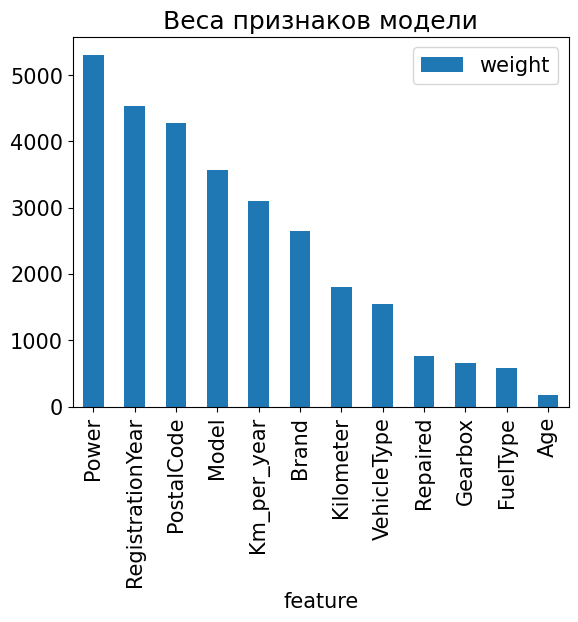

In [130]:
chart = pd.DataFrame(
    zip(GS_for_LGBMR.best_estimator_.feature_importances_, features_train.columns),
    columns=['weight', 'feature']
).sort_values('weight', ascending=False).plot(kind='bar', x='feature')
chart.set_title('Веса признаков модели', fontsize=18)
chart;

Из сводной таблицы весов характеристик видим, что в пятерку самых важных вошли:

- мощность двигателя
- регион продажи (определяется по почтовому индексу)
- год регистрации автомобиля
- модель авто
- средний пробег в год


### Вывод анализа моделей

**Показатели качества** модели **LGBMRegressor** на тестовой выборке:
- качество предсказаний - RMSE = 1552
- время обучения - 2,14 сек
- время предсказания - 0,38 сек

**Значения параметров модели**:
- force_row_wise=True
- max_depth=10,
- n_estimators=1000,
- n_jobs=8,
- num_leaves=30
- random_state=12345

**Самых важные характеристики данных**: мощность двигателя, регион продажи (определяется по почтовому индексу), год регистрации автомобиля.


## Общий вывод

Нам доступны данные, которые содержат **354 369 строк, 15 характеристик и целевой признак**.

**Проведен анализ данных**. В данных содержатся дубликаты, пропуски и аномальные значения. В результате предварительной обработки удалены аномальные значения (менее 7 % наблюдений). Для обработки пропусков **написан трансформер данных**, который можно будет **передать заказчику** вместе с моделью.

Проведен **отбор признаков**, выявлены неинформативные для модели, **добавлены новые** характеристики:
- возраст автомобиля
- средний пробег авто за год
Данные разбиты на обучающую и тестовую выборки.

На имеющихся данных **обучены три модели**: 
- LGBMRegressor, 
- CatBoostRegressor
- LinearRegression. 

Для линейной регрессии была проведена дополнительная обработка категориальных признаков и масштабирование. Для каждой модели подобраны гиперпараметры и приведены показатели качества предсказаний (RMSE), среднее время обучения по фолдам и время предсказания. 

В результате сравнения ключевых для заказчика показателей качества выбрана модель **выберем LGBMRegressor** со следующими **значениями параметров**:
- force_row_wise=True
- max_depth=10,
- n_estimators=1000,
- n_jobs=8,
-  num_leaves=30
-  random_state=12345 

Ее преимуществ (числовые данные на тестовой выборке)а:

- самое **высокое качество предсказаний** (RMSE =1552)
- самое  **низкое время обучения** (2.14 сек)
- **приемлемое время предсказания** (0.38 сек)
- более **простой процесс предобработки** данных

Проведен **анализ характеристик** лучшей модели. В **пятерку самых важных** вошли:

- мощность двигателя
- регион продажи (определяется по почтовому индексу)
- год регистрации автомобиля
- модель авто
- средний пробег в год
